In [51]:
import pandas as pd
import numpy as np
import joblib
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils import shuffle 
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc,roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score,train_test_split,cross_validate, StratifiedKFold
# 忽略烦人的红色提示
import warnings
warnings.filterwarnings("ignore")
from rdkit import Chem
import os
import pandas as pd
import numpy as np
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Descriptors
from icecream import ic
from time import time 

# 加载数据

In [52]:
df_compare_tmp = pd.read_csv("模型评价\\爬取结果进行比较.csv")
df_compare_tmp["Len"] = [len(x) for x in df_compare_tmp["PepName"]]
df_compare = df_compare_tmp[df_compare_tmp["Len"] >= 4]
df_compare = df_compare_tmp[df_compare_tmp["Len"] <= 10]

df_compare.iloc[153]

PepName            GLG
Really_Taste    Bitter
Umami_SCM            0
Bitter_SCM           0
Bitter_BERT          0
Umami_YYDS           0
Len                  3
Name: 153, dtype: object

In [53]:
df_compare_tmp[df_compare_tmp["Len"] == 10]

,PepName,Really_Taste,Umami_SCM,Bitter_SCM,Bitter_BERT,Umami_YYDS,Len
222,VYPFPPGINH,Bitter,0,0,0,1,10
225,FFRPFFRPFF,Bitter,0,0,0,1,10
244,VYPFPPIGNH,Bitter,0,0,0,1,10
249,PVRGPFPIIV,Bitter,0,0,0,1,10
305,VYPFPPGIGG,"Sour,Sweet,Salt,Umami",0,0,0,1,10
306,VYPFGGGINH,"Salt,Umami",0,0,0,1,10
391,ANPGPVRDLR,Umami,0,0,1,1,10
392,QVAIAHRDAK,Umami,1,1,1,1,10
393,AGFAGDDAPR,Umami,1,0,0,1,10
394,GYSFTTTAER,Umami,1,1,1,1,10


# 加载模型并检验
## 加载模型

测试集准确度是1.0
验证集准确度是0.8958333333333334


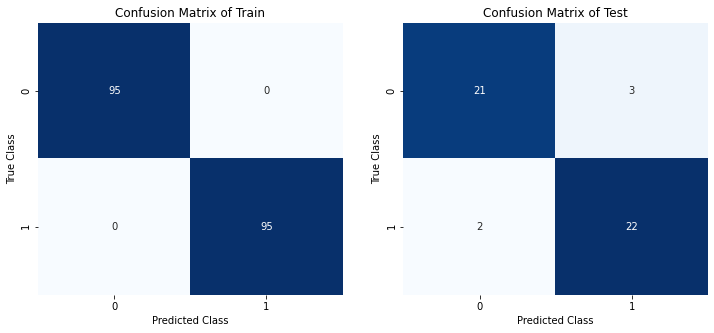

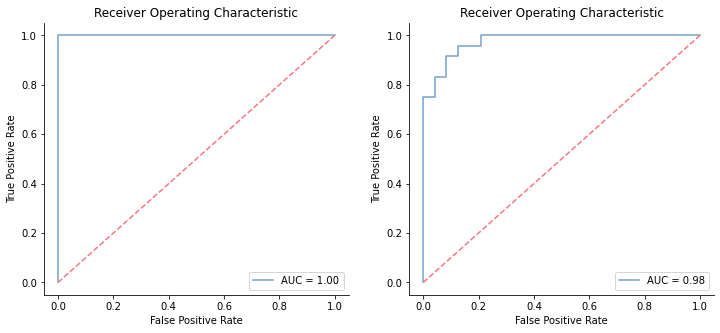

In [54]:
estimator = joblib.load('GtBossT.pkl')
df_smote = pd.read_csv("SMOTE增强数据.csv")
# 开始要进行以下标准化
X_tmp = df_smote.iloc[:,1:]
X_columns = X_tmp.columns
X_1 = StandardScaler().fit_transform(X_tmp)
X = pd.DataFrame(X_1,columns=X_columns)
Y = df_smote["taste_num"]
columns = X.columns
train_X, test_X, train_Y, test_Y = train_test_split(X,
                                                    Y,
                                                    test_size=0.2,
                                                    random_state=123,
                                                    stratify=Y)
# GTB = GradientBoostingClassifier(random_state=0,
#                                  criterion='friedman_mse',
#                                  loss='deviance',
#                                  max_depth=7,
#                                  min_samples_leaf=3,
#                                  min_samples_split=10,
#                                  n_estimators=477)

estimator = estimator
# estimator.fit(train_X, train_Y)
gtb_train = estimator.predict(train_X)
gtb_test = estimator.predict(test_X)
print(f"测试集准确度是{accuracy_score(train_Y,gtb_train)}")
print(f"验证集准确度是{accuracy_score(test_Y,gtb_test)}")

train_matrix = confusion_matrix(train_Y, gtb_train)
test_matrix = confusion_matrix(test_Y, gtb_test)

#尝试修改一下颜色
pall = sns.color_palette(['#73a2c6', '#f4777f'])
sns.set_palette(pall)

# 绘制热图
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_matrix, annot=True, cmap="Blues", cbar=None,
            fmt="d")  #cbar=None 就会不显示色条,fmt="d"确保中间现实数字
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.title("Confusion Matrix of Train")

plt.subplot(1, 2, 2)
sns.heatmap(test_matrix, annot=True, cmap="Blues", cbar=None,
            fmt="d")  #cbar=None 就会不显示色条,fmt="d"确保中间现实数字
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.title("Confusion Matrix of Test")
plt.savefig("Paper_Fig\\Model_Evaluation\\Confusion Matrix of Test.svg", dpi = 300)
plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
# 绘制训练集ROC图
y_pro_train = estimator.predict_proba(train_X)[:, 1]
# 获取预测
y_pre_train = estimator.predict(train_X)
#计算真阳和假阳概率
fpr, tpr, thresholds = roc_curve(train_Y, y_pro_train)
roc_auc = auc(fpr, tpr)  #也等于roc_auc_score(y_test,y_pro)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
plt.legend(loc="best")
plt.plot([0, 1], [0, 1], '--')
# plt.xlim([-0.1,1.1])
# plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 绘制测试集ROC图
plt.subplot(1, 2, 2)
# 获取预测的概率
y_pro_test = estimator.predict_proba(test_X)[:, 1]
# 获取预测
y_pre_test = estimator.predict(test_X)

#计算真阳和假阳概率
fpr, tpr, thresholds = roc_curve(test_Y, y_pro_test)
roc_auc = auc(fpr, tpr)  #也等于roc_auc_score(y_test,y_pro)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
plt.legend(loc="best")
plt.plot([0, 1], [0, 1], '--')
# plt.xlim([-0.1,1.1])
# plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig("Paper_Fig\\Model_Evaluation\\ROC.svg", dpi = 300)
plt.show()

## 制作FPS

In [55]:
def AA_to_des(dateframe_name):
    mols = []
    for i in dateframe_name["PepName"]:
        mol = Chem.MolFromFASTA(i)
        mols.append(mol)

    descs = [desc_name[0] for desc_name in Descriptors._descList]

    # 展示一下所有的特征名单
#     print(f"共有{len(mols)}个化合物", end="______");
#     print(f"共有{len(descs)}个特征")
#     print(f"特征如下：{[i for i in descs]}")

    #计算描述符
    desc_calc = MoleculeDescriptors.MolecularDescriptorCalculator(descs)
    descriptors = pd.DataFrame(desc_calc.CalcDescriptors(mol) for mol in mols)
    descriptors.columns = descs

    #使用方差来选择特征,m目的是为去除全0特征 ,我这里不需要这个功能，不然有一些肽，就会被直接筛选掉
#     from sklearn.feature_selection import VarianceThreshold
#     X = descriptors.values
#     select = VarianceThreshold()
#     X_new = select.fit_transform(X)
    
#     desc_new_df = pd.DataFrame(X_new, columns=np.array(descs)[select.get_support()==True])
# #     print(desc_new_df.head())
# #     print(desc_new_df.shape)
    
    return descriptors 
result = AA_to_des(df_compare[["PepName"]])
result

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,11.055487,-1.272917,11.055487,0.163565,0.441251,218.209,204.097,218.090272,86,0,...,0,0,0,0,0,0,0,0,0,0
1,11.780656,-1.057874,11.780656,0.133428,0.185084,287.364,262.164,287.195740,116,0,...,0,0,0,0,0,0,0,0,1,0
2,11.690481,-1.233611,11.690481,0.018497,0.420983,295.295,278.159,295.116821,114,0,...,0,0,0,0,0,0,0,0,0,0
3,11.030602,-1.227500,11.030602,0.529591,0.425418,204.182,192.086,204.074621,80,0,...,0,0,0,0,0,0,0,0,0,0
4,11.412091,-1.234711,11.412091,0.089906,0.474482,246.263,228.119,246.121572,98,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,13.815722,-2.025698,13.815722,0.034491,0.032774,936.999,880.551,936.364732,358,0,...,1,0,0,0,0,0,0,0,1,0
408,13.598703,-1.724521,13.598703,0.127347,0.031978,1004.021,942.533,1003.424689,390,0,...,0,0,0,0,0,0,0,0,0,0
409,13.758721,-1.889965,13.758721,0.012052,0.012803,1097.264,1020.656,1096.533529,426,0,...,0,0,0,0,0,0,0,0,3,0
410,13.727583,-1.833797,13.727583,0.049666,0.031125,922.991,860.495,922.439611,362,0,...,0,0,0,0,0,0,0,0,1,0


In [56]:
X_my = result[columns]  # 得到八大标准格式
# tmp_tmp = pd.concat([df_compare[["PepName"]],X_my],axis=1)
# # tmp_tmp.to_csv("有缺失的值.csv",index=False)
# import missingno as msno
# msno.matrix(df_X,color=(0.25, 0.25, 0.5))

## 经过同样的标准化

In [57]:
from sklearn.preprocessing import StandardScaler
df_smote = pd.read_csv("SMOTE增强数据.csv")
# 开始要进行以下标准化
X_tmp = df_smote.iloc[:,1:]
X_columns = X_tmp.columns
A = StandardScaler()
AAAA= A.fit(X_tmp)

X_MY =A.transform(X_my)
df_X = pd.DataFrame(X_MY,columns=X.columns)

## 得到我们的判断结果

In [58]:
y_pre_test = estimator.predict(df_X)
df_compare["Umami_YYDS"]=y_pre_test
df_compare

,PepName,Really_Taste,Umami_SCM,Bitter_SCM,Bitter_BERT,Umami_YYDS,Len
0,AE,Umami,1,1,1,1,2
1,RL,Umami,1,1,1,1,2
2,NY,Umami,1,1,1,1,2
3,DA,Umami,1,0,0,1,2
4,DL,Umami,1,0,0,1,2
...,...,...,...,...,...,...,...
430,NWDDMEK,"Sweet,Umami",1,1,1,1,7
431,EFEGGSIEH,Umami,0,0,0,1,9
432,YKCKDGDLR,"Umami,Kokumi",0,0,1,1,9
433,ASLDGEFKG,"Sweet,Umami,Kokumi",1,1,1,1,9


# 剔除矛盾肽

In [59]:
## 比较两个列表A和B是否A包含于B，可以比较有间隔的列表
def allin(A, B):
    """
    判断A在B里面
    a = ["Umami","Bitter"]
    b = ["Bitter","Sour","Umami"]
    True
    """
    A.sort()  # 因为排序了，所以对于先后顺序没有要求了
    B.sort()
    if len(A) > len(B): return False
    k = 0
    for i in range(0,len(A)):
        for j in range(k,len(B)):
            if A[i] == B[j]:
                if i == len(A)-1:
                    return True
                else:
                    break
        if j < len(B)-1:
            k = j+1
        else:
            break
    return False

In [60]:
df_4 = df_compare
df_4["Taste_num"] = 0        # 这一列存储 Umami→2 ， Bitter→1
a = ["Umami","Bitter"]
# 下面开始循环赋值
for i in range(df_4.shape[0]):
    if allin(a,df_4["Really_Taste"].iloc[i].split(",")):
        df_4["Taste_num"].iloc[i] = 2.0
    elif  allin(["Umami"],df_4["Really_Taste"].iloc[i].split(",")):
        df_4["Taste_num"].iloc[i] = 1.0
    elif  allin(["Bitter"],df_4["Really_Taste"].iloc[i].split(",")):
        df_4["Taste_num"].iloc[i] = 0
    else:
        df_4["Taste_num"].iloc[i] = 3.0
  

df_5 = df_4.query("1 >= Taste_num >= 0")
df_5.to_csv("模型评价\\剔除矛盾数据的4肽及以上比较数据.csv",index=False)
df_5

,PepName,Really_Taste,Umami_SCM,Bitter_SCM,Bitter_BERT,Umami_YYDS,Len,Taste_num
0,AE,Umami,1,1,1,1,2,1
1,RL,Umami,1,1,1,1,2,1
2,NY,Umami,1,1,1,1,2,1
3,DA,Umami,1,0,0,1,2,1
4,DL,Umami,1,0,0,1,2,1
...,...,...,...,...,...,...,...,...
430,NWDDMEK,"Sweet,Umami",1,1,1,1,7,1
431,EFEGGSIEH,Umami,0,0,0,1,9,1
432,YKCKDGDLR,"Umami,Kokumi",0,0,1,1,9,1
433,ASLDGEFKG,"Sweet,Umami,Kokumi",1,1,1,1,9,1


# 比较结果
## 建立df的list列表

In [61]:
RESULT_list = []
for index,name in enumerate(["Umami_SCM","Bitter_SCM","Umami_YYDS","Bitter_BERT"]):
    tmp = "df_"+ name
    tmp = df_compare.loc[:,["PepName","Taste_num",name,"Len"]]
    RESULT_list.append(tmp)

In [62]:
RESULT_list[0]

,PepName,Taste_num,Umami_SCM,Len
0,AE,1,1,2
1,RL,1,1,2
2,NY,1,1,2
3,DA,1,1,2
4,DL,1,1,2
...,...,...,...,...
430,NWDDMEK,1,1,7
431,EFEGGSIEH,1,0,9
432,YKCKDGDLR,1,0,9
433,ASLDGEFKG,1,1,9


## 评价函数
学习资料：https://blog.csdn.net/sinat_36972314/article/details/82734370

In [63]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import average_precision_score, balanced_accuracy_score, matthews_corrcoef, precision_score, recall_score
from sklearn.utils import shuffle
import seaborn as sns

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
# 恢复默认参数
# mpl.rcdefaults()
# z自定义matplotlib的颜色映射
import matplotlib
import matplotlib.colors as col
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np


def estimator_function(df_Really, df_Predict):
    """
    df_Really  是真实结果
    df_Predict 是预测结果
    
    """
    return none

## 整体评价
### 混淆矩阵，看看就好

Umami_SCM
准确度是0.7378640776699029
Average precision-recall score: 0.67
Average recall score: 0.73
0.4847554393569367
Bitter_SCM
准确度是0.6407766990291263
Average precision-recall score: 0.58
Average recall score: 0.63
0.29672474773669905
Umami_YYDS
准确度是0.7354368932038835
Average precision-recall score: 0.65
Average recall score: 0.74
0.47337921568493696
Bitter_BERT
准确度是0.6990291262135923
Average precision-recall score: 0.64
Average recall score: 0.69
0.4173808069572435


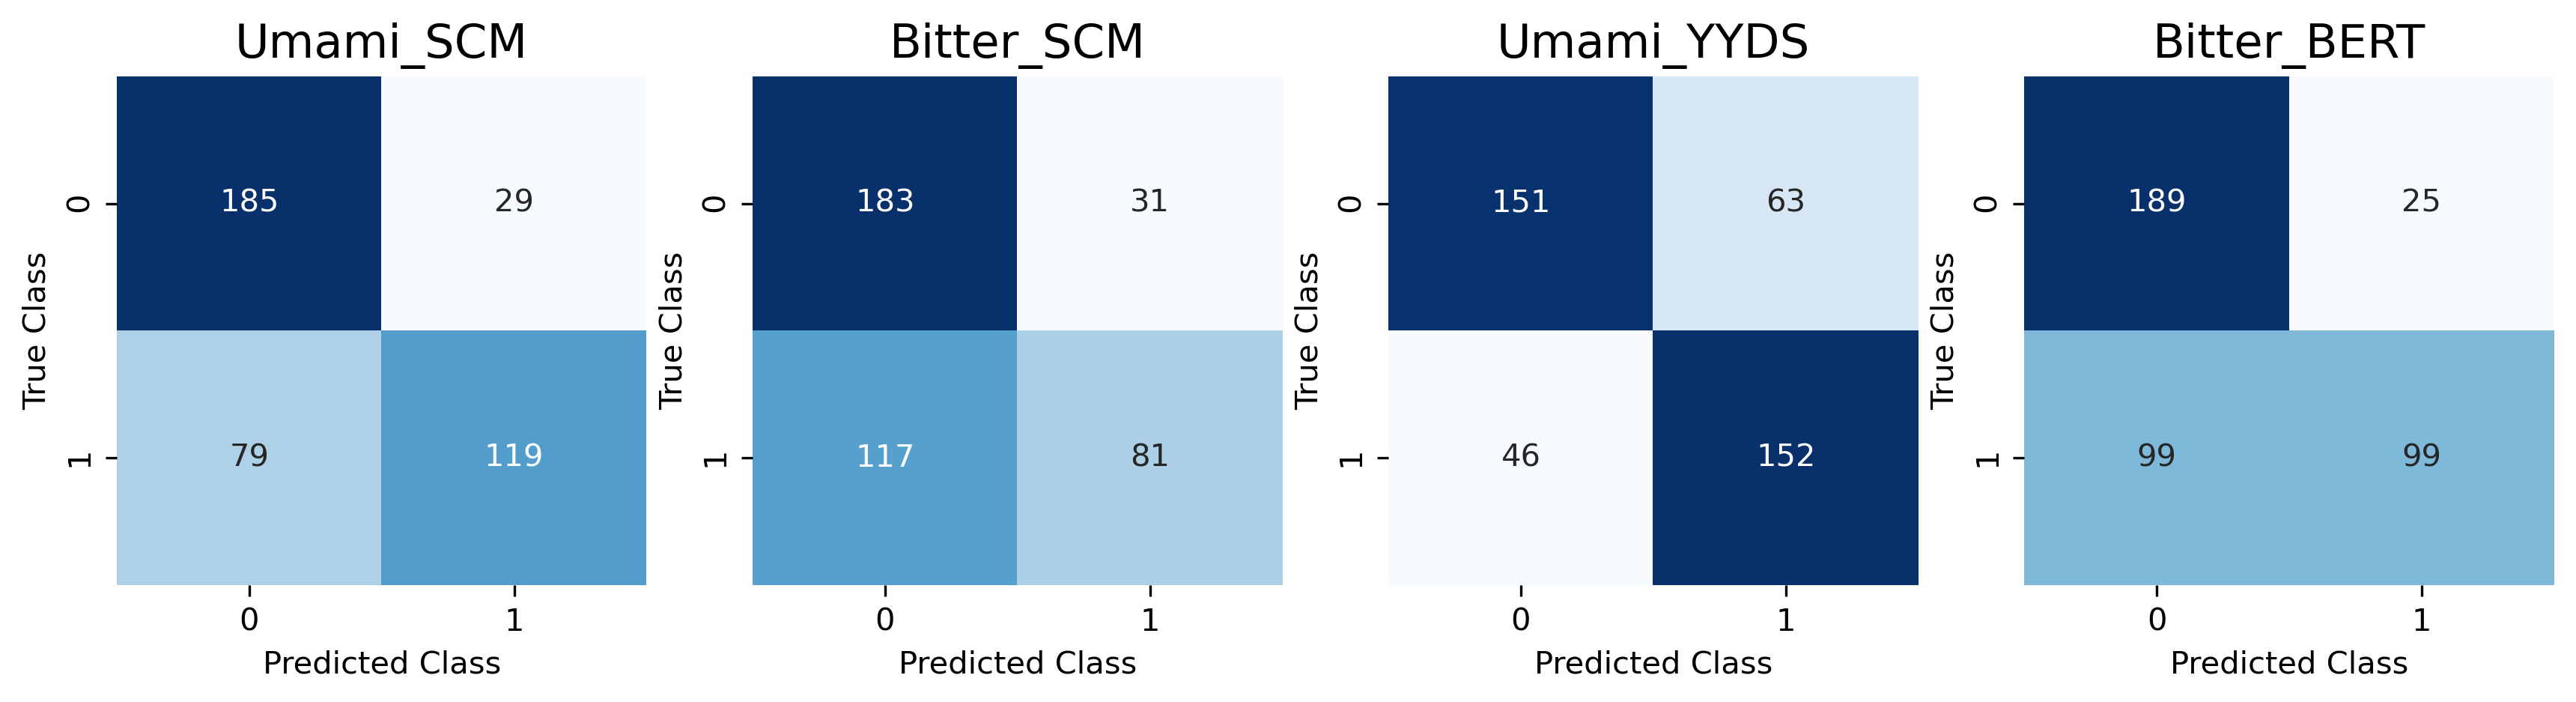

In [64]:
fig = plt.figure(figsize=(14, 3),dpi=300)
fig.subplots_adjust(hspace=0.3)
ax1 = fig.add_subplot(1, 4, 1)
ax2 = fig.add_subplot(1, 4, 2)
ax3 = fig.add_subplot(1, 4, 3)
ax4 = fig.add_subplot(1, 4, 4)

ax = [ax1,ax2,ax3,ax4]
for index,name in enumerate(["Umami_SCM","Bitter_SCM","Umami_YYDS","Bitter_BERT"]):
    print(name)
    ax[index].set_title(name,fontsize=15)
    df_Really = RESULT_list[index]["Taste_num"]
    df_Predict = RESULT_list[index][name]
    print(f"准确度是{accuracy_score(df_Really,df_Predict)}")
    test_matrix = confusion_matrix(df_Really,df_Predict)
    # 绘制热图
    sns.heatmap(test_matrix,annot=True,cmap="Blues",cbar=None,fmt="d",ax=ax[index])  #cbar=None 就会不显示色条,fmt="d"确保中间现实数字
    ax[index].set_ylabel('True Class',fontsize=10)
    ax[index].set_xlabel('Predicted Class',fontsize=10)
    
    average_precision = average_precision_score(df_Really, df_Predict)
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))
    
    average_recall = balanced_accuracy_score(df_Really, df_Predict)
    print('Average recall score: {0:0.2f}'.format(average_recall))
    
    Matthews_corrcoef = matthews_corrcoef(df_Really, df_Predict)
#     print('matthews_corrcoef: {0:0.2f}'.format(Matthews_corrcoef))
    print(Matthews_corrcoef)
    
plt.savefig("Paper_Fig\\Model_Evaluation\\混淆矩阵对比.svg",bbox_inches="tight")

### 制作对比图

In [65]:
from sklearn.metrics import accuracy_score,average_precision_score,balanced_accuracy_score,  matthews_corrcoef, precision_score, recall_score,f1_score

df_list = [ "Umami_SCM", "Bitter_SCM","Umami_YYDS", "Bitter_BERT"]
df_column = [
    "Accuracy", "Precision", "Recall", "F1",
#     "Balanced_accuracy",
#     "Average Precision",
    "Matthews Corrcoef","Label"
]
tmp = np.zeros((len(df_list), len(df_column)))
df_scores = pd.DataFrame(tmp, index=df_list, columns=df_column)
for index, name in enumerate([ "Umami_SCM","Bitter_SCM","Umami_YYDS",  "Bitter_BERT"]):
    df_Really = RESULT_list[index]["Taste_num"]
    df_Predict = RESULT_list[index][name]
    tmp1 = accuracy_score(df_Really, df_Predict)  # 准确率
    tmp2 = precision_score(df_Really, df_Predict)  # 精准度    预测为正类且预测正确的数量/预测为正类的数量
    tmp3 = recall_score(df_Really, df_Predict)  # 召回率
    tmp4 = f1_score(df_Really, df_Predict)  #  召回率和精准率的调和值
#     tmp5 = balanced_accuracy_score(df_Really, df_Predict)
#     tmp6 = average_precision_score(df_Really, df_Predict)  # 平均准确度
    tmp7 = matthews_corrcoef(df_Really, df_Predict)  # 马修斯相关系数
    df_scores[df_column[0]].loc[name] = tmp1
    df_scores[df_column[1]].loc[name] = tmp2
    df_scores[df_column[2]].loc[name] = tmp3
    df_scores[df_column[3]].loc[name] = tmp4
#     df_scores[df_column[4]].loc[name] = tmp5
#     df_scores[df_column[5]].loc[name] = tmp6
    df_scores[df_column[4]].loc[name] = tmp7
    df_scores[df_column[5]].loc[name] = name
    
    
df_scores

,Accuracy,Precision,Recall,F1,Matthews Corrcoef,Label
Umami_SCM,0.737864,0.804054,0.601010,0.687861,0.484755,Umami_SCM
Bitter_SCM,0.640777,0.723214,0.409091,0.522581,0.296725,Bitter_SCM
Umami_YYDS,0.735437,0.706977,0.767677,0.736077,0.473379,Umami_YYDS
Bitter_BERT,0.699029,0.798387,0.500000,0.614907,0.417381,Bitter_BERT


In [66]:
df_tmp = df_scores.melt(id_vars="Label")
df_tmp.to_csv("各方法总体结果对比.csv",index=False)
df_tmp

,Label,variable,value
0,Umami_SCM,Accuracy,0.737864
1,Bitter_SCM,Accuracy,0.640777
2,Umami_YYDS,Accuracy,0.735437
3,Bitter_BERT,Accuracy,0.699029
4,Umami_SCM,Precision,0.804054
5,Bitter_SCM,Precision,0.723214
6,Umami_YYDS,Precision,0.706977
7,Bitter_BERT,Precision,0.798387
8,Umami_SCM,Recall,0.601010
9,Bitter_SCM,Recall,0.409091


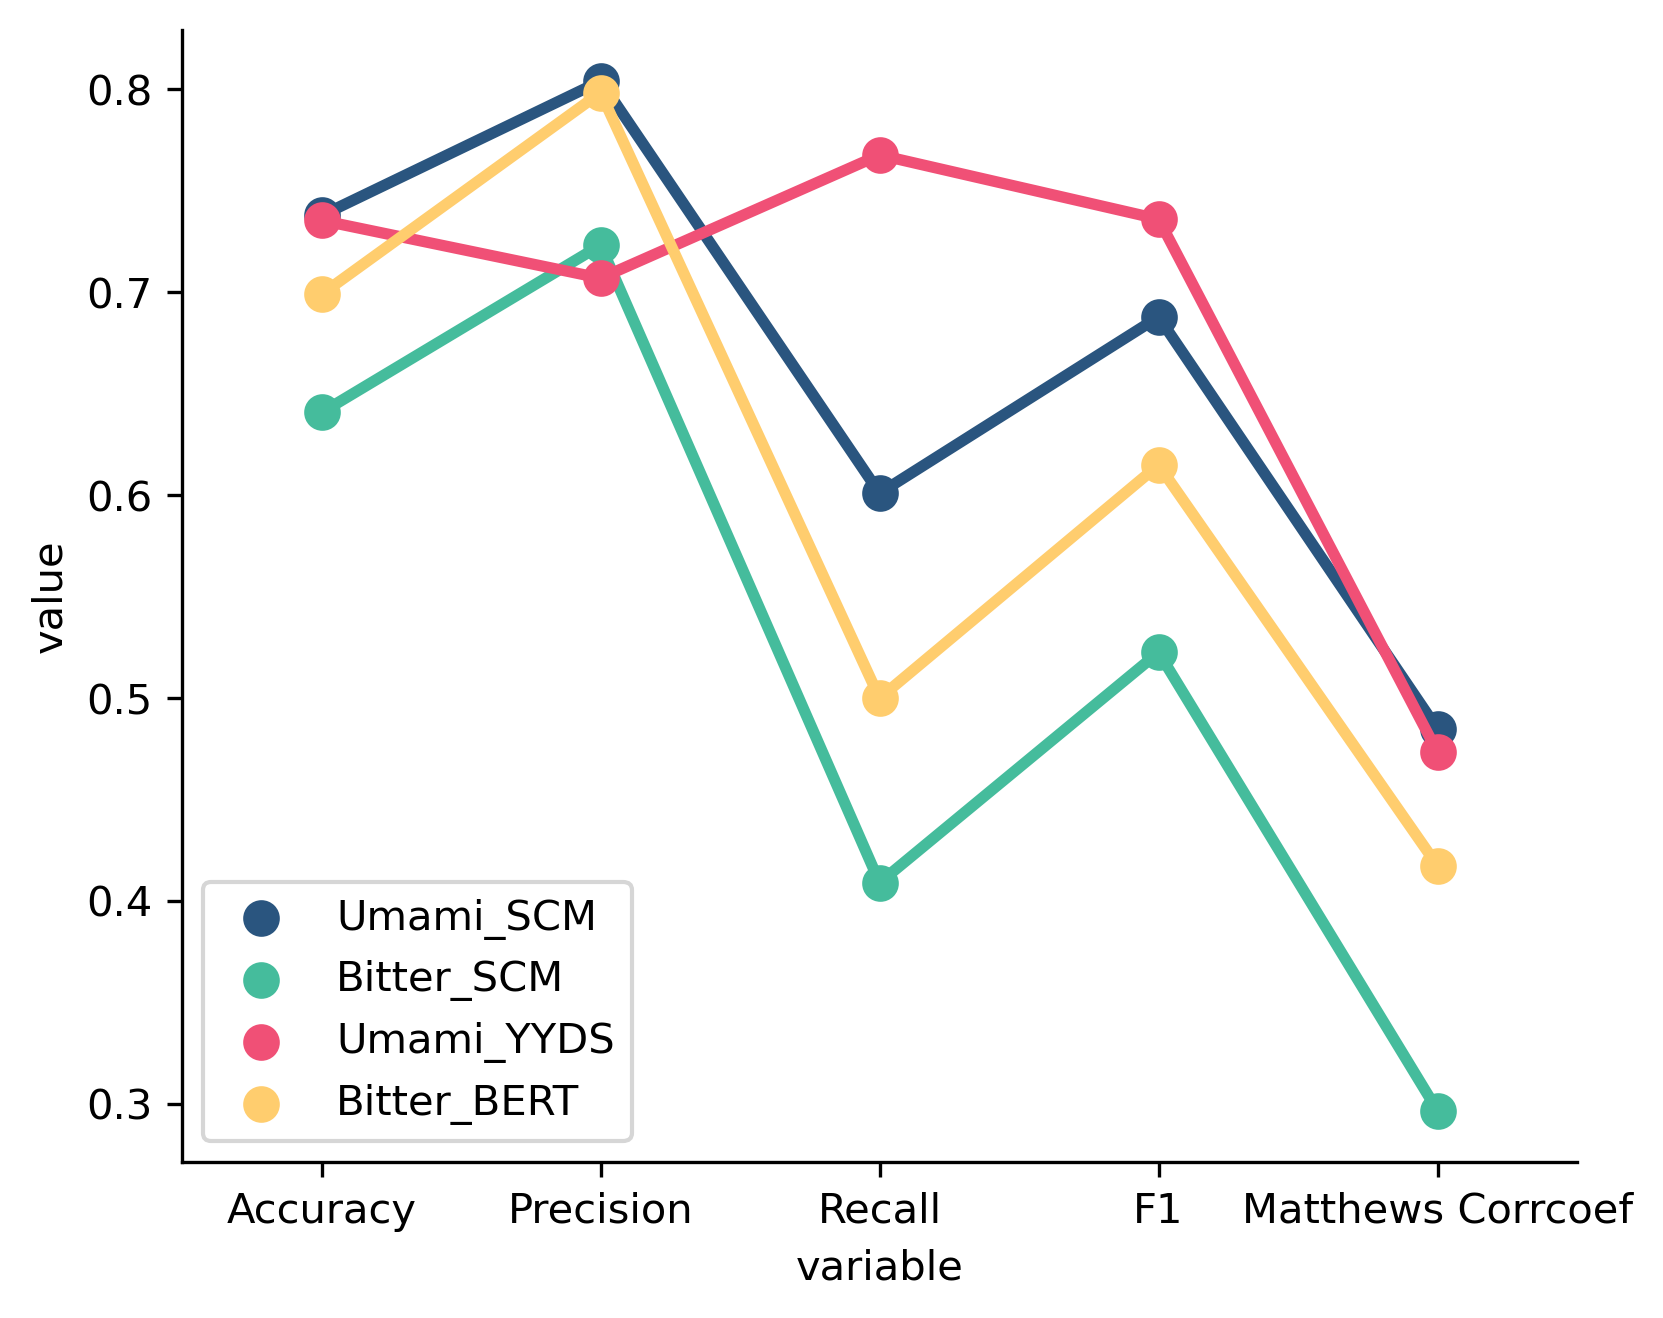

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
df_tmp = pd.read_csv("各方法总体结果对比.csv")

pal2 = sns.color_palette(['#2a557f','#45bc9c','#f05076','#ffcd6e'])
sns.set_palette(pal2)
    
fig = plt.figure(figsize=(6, 5),dpi=300)
sns.pointplot(x="variable", y="value", hue="Label",
            data=df_tmp)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc="lower left")
# ax.set_xticklabels(ax.get_xticklabels(), rotation= 45,fontsize=12)
plt.savefig("Paper_Fig\\Model_Evaluation\\4肽及以上建模对比.svg",bbox_inches="tight")

In [68]:
# df_5[df_5["Len"]==7]
# df_Really = df_5[df_5["Len"]==7]["Taste_num"]
# df_Predict = df_5[df_5["Len"]==7]["Umami_SCM"]
# tmp1 = accuracy_score(df_Really, df_Predict)  # 准确率
# tmp2 = precision_score(df_Really, df_Predict)  # 精准度
# print(tmp1)
# print(tmp2)


## 做一个逐级特征比较

In [69]:
def scores_cal(df_compare,num):
    
    print(num)
    RESULT_list = []
    for index,name in enumerate(["Umami_SCM","Bitter_SCM","Bitter_BERT","Umami_YYDS"]):
        tmp = "df_"+ name
        tmp = df_compare.loc[:,["PepName","Taste_num",name,"Len"]]
        RESULT_list.append(tmp)
    
    
    df_list = ["Umami_SCM", "Bitter_SCM", "Bitter_BERT", "Umami_YYDS"]
    df_column = [
        "Accuracy", "Precision", "Recall", "F1", 
#         "Balanced_accuracy",
#         "Average Precision",
        "Matthews Corrcoef","Label","Len"
    ]
    tmp = np.zeros((len(df_list), len(df_column)))
    df_scores = pd.DataFrame(tmp, index=df_list, columns=df_column)
    for index, name in enumerate(
        ["Umami_SCM", "Bitter_SCM", "Bitter_BERT", "Umami_YYDS"]):
        df_Really = RESULT_list[index]["Taste_num"]
        df_Predict = RESULT_list[index][name]
        tmp1 = accuracy_score(df_Really, df_Predict)  # 准确率
        tmp2 = precision_score(df_Really, df_Predict)  # 精准度
        tmp3 = recall_score(df_Really, df_Predict)  # 召回率
        tmp4 = f1_score(df_Really, df_Predict)  #  召回率和精准率的调和值
#         tmp5 = balanced_accuracy_score(df_Really, df_Predict)
#         tmp6 = average_precision_score(df_Really, df_Predict)  # 平均准确度
        tmp7 = matthews_corrcoef(df_Really, df_Predict)  # 马修斯相关系数
        df_scores[df_column[0]].loc[name] = tmp1
        df_scores[df_column[1]].loc[name] = tmp2
        df_scores[df_column[2]].loc[name] = tmp3
        df_scores[df_column[3]].loc[name] = tmp4
#         df_scores[df_column[4]].loc[name] = tmp5
#         df_scores[df_column[5]].loc[name] = tmp6
        df_scores[df_column[4]].loc[name] = tmp7
        df_scores[df_column[5]].loc[name] = name
        df_scores[df_column[6]].loc[name] = num
        df_tmp = df_scores.melt(id_vars=["Label","Len"])
        
    return df_tmp



In [70]:
for num in range(4,11):
    df_tmp = df_5[df_5["Len"]==num]
    df_scores = scores_cal(df_tmp,num)
    if num == 4:
        Result_DF = df_scores
    else:
        tmp = pd.concat([Result_DF,df_scores])
        Result_DF = tmp
        

Result_DF

4
5
6
7
8
9
10


,Label,Len,variable,value
0,Umami_SCM,4.0,Accuracy,0.810811
1,Bitter_SCM,4.0,Accuracy,0.837838
2,Bitter_BERT,4.0,Accuracy,0.810811
3,Umami_YYDS,4.0,Accuracy,0.567568
4,Umami_SCM,4.0,Precision,0.300000
...,...,...,...,...
15,Umami_YYDS,10.0,F1,0.842105
16,Umami_SCM,10.0,Matthews Corrcoef,0.426401
17,Bitter_SCM,10.0,Matthews Corrcoef,0.301511
18,Bitter_BERT,10.0,Matthews Corrcoef,0.644658


In [71]:
Result_DF.to_csv("各方法逐级展示结果.csv",index=False)

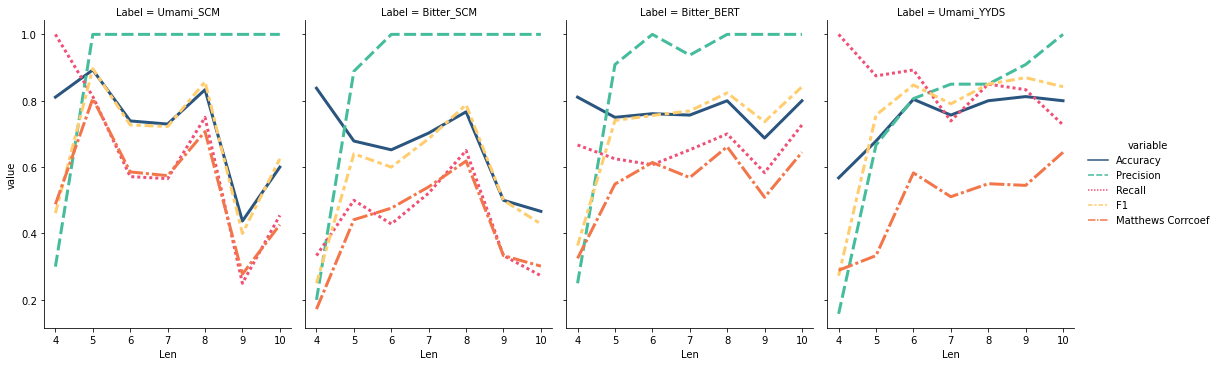

In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pal2 = sns.color_palette(['#2a557f','#45bc9c','#f05076','#ffcd6e','#F3764A'])
sns.set_palette(pal2)

sns.relplot(
    data=Result_DF,
    x="Len", y="value",
    hue="variable", col='Label',style="variable",
    kind="line", height=5, aspect=.75, facet_kws=dict(sharex=False),linewidth=3
)
plt.savefig("Paper_Fig\\Model_Evaluation\\4肽及以上建模逐级对比.svg",bbox_inches="tight")

In [73]:
Result_DF

,Label,Len,variable,value
0,Umami_SCM,4.0,Accuracy,0.810811
1,Bitter_SCM,4.0,Accuracy,0.837838
2,Bitter_BERT,4.0,Accuracy,0.810811
3,Umami_YYDS,4.0,Accuracy,0.567568
4,Umami_SCM,4.0,Precision,0.300000
...,...,...,...,...
15,Umami_YYDS,10.0,F1,0.842105
16,Umami_SCM,10.0,Matthews Corrcoef,0.426401
17,Bitter_SCM,10.0,Matthews Corrcoef,0.301511
18,Bitter_BERT,10.0,Matthews Corrcoef,0.644658
